Training with optimizer: Gradient Descent
Training with optimizer: Stochastic Gradient Descent
Training with optimizer: Mini-batch Gradient Descent
Training with optimizer: Nesterov’s Accelerated Gradient
Training with optimizer: Adam
Training with optimizer: AdaGrad
Training with optimizer: AMSGrad
Training with optimizer: RMSProp
Training with optimizer: Momentum


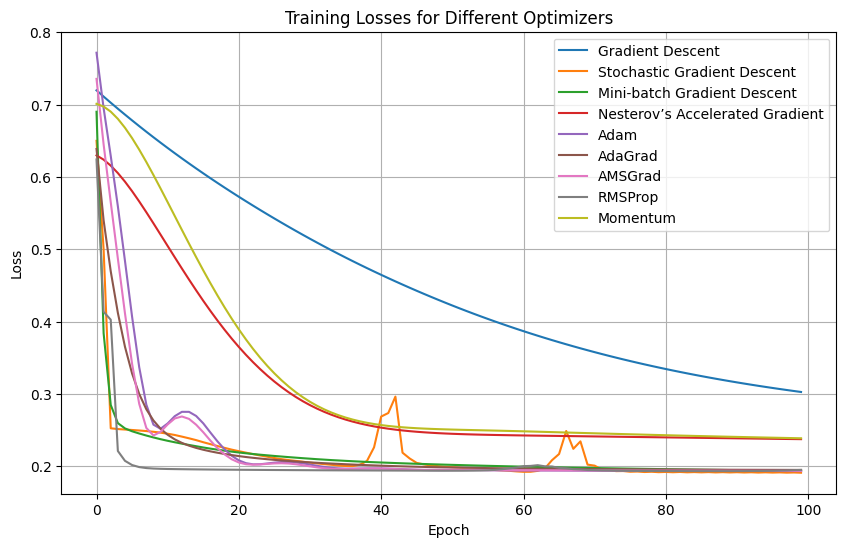

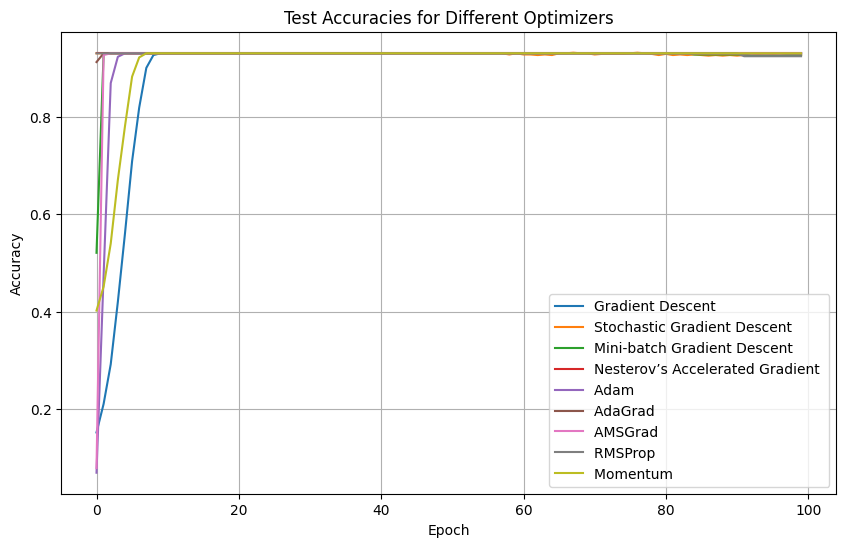

In [12]:
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the Karate Club graph
karate_graph = nx.karate_club_graph()

# Generate positive examples (edges) and negative examples (non-edges)
positive_edges = list(karate_graph.edges())
num_nodes = karate_graph.number_of_nodes()
negative_edges = [(i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j and not karate_graph.has_edge(i, j)]

# Label positive examples with 1 and negative examples with 0
labels = [1] * len(positive_edges) + [0] * len(negative_edges)
edges = positive_edges + negative_edges

# Split data into training and testing sets
edges_train, edges_test, labels_train, labels_test = train_test_split(edges, labels, test_size=0.2, random_state=42)

# Convert edges to PyTorch tensors
edges_train_tensor = torch.LongTensor(edges_train)
edges_test_tensor = torch.LongTensor(edges_test)
labels_train_tensor = torch.FloatTensor(labels_train)
labels_test_tensor = torch.FloatTensor(labels_test)

# Define a simple Graph Neural Network model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.conv1 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, edges):
        x = self.embedding(edges)
        x = x.permute(0, 2, 1)  # Adjust shape for convolution
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.mean(x, dim=-1)  # Global pooling
        x = self.fc(x)
        return torch.sigmoid(x)

# Define optimizer names and optimizer instances
optimizers = {
    'Gradient Descent': torch.optim.SGD,
    'Stochastic Gradient Descent': torch.optim.SGD,
    'Mini-batch Gradient Descent': torch.optim.SGD,
    'Nesterov’s Accelerated Gradient': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'AdaGrad': torch.optim.Adagrad,
    'AMSGrad': torch.optim.Adam,
    'RMSProp': torch.optim.RMSprop,
    'Momentum' : torch.optim.SGD
}

# Define parameters for each optimizer
optimizer_params = {
    'Gradient Descent': {'lr': 0.01},
    'Stochastic Gradient Descent': {'lr': 0.01},
    'Mini-batch Gradient Descent': {'lr': 0.01},
    'Nesterov’s Accelerated Gradient': {'lr': 0.01, 'momentum': 0.9, 'nesterov': True},
    'Adam': {'lr': 0.01},
    'AdaGrad': {'lr': 0.01},
    'AMSGrad': {'lr': 0.01},
    'RMSProp': {'lr': 0.01},
    'Momentum': {'lr': 0.01, 'momentum': 0.9}
}

# Define a function to train the model with a given optimizer
# Define a function to train the model with a given optimizer
def train_model(optimizer_name, model, criterion, optimizer, edges_train_tensor, labels_train_tensor, edges_test_tensor, labels_test_tensor, epochs=100):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(edges_train_tensor)
        loss = criterion(outputs.squeeze(), labels_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Compute training accuracy
        train_preds = (outputs > 0.5).squeeze().detach().numpy()
        train_accuracy = np.mean(train_preds == labels_train_tensor.numpy())
        train_accuracies.append(train_accuracy)

        # Compute test accuracy
        test_outputs = model(edges_test_tensor)
        test_preds = (test_outputs > 0.5).squeeze().detach().numpy()
        test_accuracy = np.mean(test_preds == labels_test_tensor.numpy())
        test_accuracies.append(test_accuracy)

    return train_losses, train_accuracies, test_accuracies

# Train the model with each optimizer and record the training losses and accuracies
train_losses_dict = {}
train_accuracies_dict = {}
test_accuracies_dict = {}

for optimizer_name in optimizers.keys():
    print(f"Training with optimizer: {optimizer_name}")
    model = GNN(num_nodes, 32, 1)
    criterion = nn.BCELoss()

    optimizer = optimizers[optimizer_name](model.parameters(), **optimizer_params[optimizer_name])
    train_losses, train_accuracies, test_accuracies = train_model(optimizer_name, model, criterion, optimizer, edges_train_tensor, labels_train_tensor, edges_test_tensor, labels_test_tensor)
    train_losses_dict[optimizer_name] = train_losses
    train_accuracies_dict[optimizer_name] = train_accuracies
    test_accuracies_dict[optimizer_name] = test_accuracies

# Plot the training losses and accuracies for each optimizerplt.figure(figsize=(10,12))

# Plot training losses

plt.figure(figsize=(10, 6))
for optimizer_name, train_losses in train_losses_dict.items():
    plt.plot(train_losses, label=optimizer_name)
plt.title('Training Losses for Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Plot training and test accuracies
plt.figure(figsize=(10, 6))
for optimizer_name, train_accuracies in train_accuracies_dict.items():
    plt.plot(train_accuracies, label=f'{optimizer_name} ', linestyle='-')
#for optimizer_name, test_accuracies in test_accuracies_dict.items():
    #plt.plot(test_accuracies, label=f'{optimizer_name} (Test)', linestyle='--')
plt.title('Test Accuracies for Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#plt.tight_layout()
plt.show()


